In [ ]:
from huggingface_hub import login
login()


In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel("dataset.xlsx")


In [ ]:
  def clean_text(text):
      text = re.sub(r"http\S+", "", str(text))
      text = re.sub(r"@\w+", "", text)
      text = re.sub(r"#\w+", "", text)
      return text.strip()

  df = df.dropna(subset=["full_text", "label"])
  df["clean_text"] = df["full_text"].apply(clean_text)
  print(df.head())

   conversation_id_str                      created_at  favorite_count  \
0  1919363195979940096  Tue May 06 22:56:03 +0000 2025               1   
1  1919775484776440064  Tue May 06 15:54:50 +0000 2025               2   
2  1919747559662490112  Tue May 06 15:20:32 +0000 2025               0   
3  1919735516687209984  Tue May 06 12:50:23 +0000 2025               0   
4  1919735516687209984  Tue May 06 12:47:43 +0000 2025               3   

                                           full_text               id_str  \
0  @Baktiar1772371 Beda jenis Bang. Kalo kucing h...  1919888921078449920   
1  @GuarEmperor Siap direkrut masuk sirkel elite ...  1919782921155510016   
2                @ooovgbnd Alhamdulillah masih dapet  1919774287340379904   
3  @satyaXBT pasti adalah.. carinya di resto khus...  1919736501673289984   
4  @satyaXBT gasss pindah negara dong ketuaa.. wk...  1919735828202589952   

  image_url in_reply_to_screen_name lang location  quote_count  reply_count  \
0       NaN  

In [ ]:
for i, row in df.head(5).iterrows():
    print(f"Original : {row['full_text']}")
    print(f"Cleaned  : {row['clean_text']}")
    print("-" * 50)


Original : @Baktiar1772371 Beda jenis Bang. Kalo kucing hutan gedenya gak segede Bobcat ini.. 
Cleaned  : Beda jenis Bang. Kalo kucing hutan gedenya gak segede Bobcat ini..
--------------------------------------------------
Original : @GuarEmperor Siap direkrut masuk sirkel elite mas GE
Cleaned  : Siap direkrut masuk sirkel elite mas GE
--------------------------------------------------
Original : @ooovgbnd Alhamdulillah masih dapet
Cleaned  : Alhamdulillah masih dapet
--------------------------------------------------
Original : @satyaXBT pasti adalah.. carinya di resto khusus indo biasanya wkwkwk
Cleaned  : pasti adalah.. carinya di resto khusus indo biasanya wkwkwk
--------------------------------------------------
Original : @satyaXBT gasss pindah negara dong ketuaa.. wkwkwk
Cleaned  : gasss pindah negara dong ketuaa.. wkwkwk
--------------------------------------------------


In [ ]:
# Konversi kolom created_at
df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
df["created_at"] = df["created_at"].dt.tz_convert(None)

# Hitung rata-rata unggahan per hari
df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["days_active"] = df["days_active"].replace(0, 1)
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]

# Bersihkan kolom bantu
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)


<ipython-input-6-2a843418cc92>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"], utc=True)


In [ ]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,clean_text,tweet_per_day
0,1919363195979940096,2025-05-06 22:56:03,1,@Baktiar1772371 Beda jenis Bang. Kalo kucing h...,1919888921078449920,NaN,Baktiar1772371,in,NaN,0,0,0,https://x.com/turtle_arc/status/19198889210784...,1630888763852460032,turtle_arc,bot,Beda jenis Bang. Kalo kucing hutan gedenya gak...,8.350877
1,1919775484776440064,2025-05-06 15:54:50,2,@GuarEmperor Siap direkrut masuk sirkel elite ...,1919782921155510016,NaN,GuarEmperor,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197829211555...,1630888763852460032,turtle_arc,bot,Siap direkrut masuk sirkel elite mas GE,8.350877
2,1919747559662490112,2025-05-06 15:20:32,0,@ooovgbnd Alhamdulillah masih dapet,1919774287340379904,NaN,ooovgbnd,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197742873403...,1630888763852460032,turtle_arc,bot,Alhamdulillah masih dapet,8.350877
3,1919735516687209984,2025-05-06 12:50:23,0,@satyaXBT pasti adalah.. carinya di resto khus...,1919736501673289984,NaN,satyaXBT,in,NaN,0,0,0,https://x.com/turtle_arc/status/19197365016732...,1630888763852460032,turtle_arc,bot,pasti adalah.. carinya di resto khusus indo bi...,8.350877
4,1919735516687209984,2025-05-06 12:47:43,3,@satyaXBT gasss pindah negara dong ketuaa.. wk...,1919735828202589952,NaN,satyaXBT,in,NaN,0,1,0,https://x.com/turtle_arc/status/19197358282025...,1630888763852460032,turtle_arc,bot,gasss pindah negara dong ketuaa.. wkwkwk,8.350877


In [ ]:
numerical_cols = ["favorite_count", "retweet_count", "reply_count", "quote_count", "tweet_per_day"]
df[numerical_cols] = df[numerical_cols].fillna(0)

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [ ]:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

In [ ]:
def tokenize(text):
    return text.split()

tokenized_texts = df["clean_text"].apply(tokenize)

from collections import Counter
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(tokens):
    return [vocab.get(token, 1) for token in tokens]

encoded_texts = [torch.tensor(encode(tokens)) for tokens in tokenized_texts]
padded_texts = torch.nn.utils.rnn.pad_sequence(encoded_texts, batch_first=True)


In [ ]:
text_tensor = padded_texts
numerical_tensor = torch.tensor(df[numerical_cols].values, dtype=torch.float32)
label_tensor = torch.tensor(df["label_encoded"].values)

X_train, X_test, num_train, num_test, y_train, y_test = train_test_split(
    text_tensor, numerical_tensor, label_tensor, test_size=0.2, random_state=42
)


In [ ]:
class BotDataset(Dataset):
    def __init__(self, texts, numerics, labels):
        self.texts = texts
        self.numerics = numerics
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.numerics[idx], self.labels[idx]

train_dataset = BotDataset(X_train, num_train, y_train)
test_dataset = BotDataset(X_test, num_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
class GRUBotDetector(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_numeric, output_dim):
        super(GRUBotDetector, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.bn_text = nn.BatchNorm1d(hidden_dim * 2)
        self.fc_text = nn.Linear(hidden_dim * 2, 64)

        self.bn_num = nn.BatchNorm1d(num_numeric)
        self.fc_numeric = nn.Linear(num_numeric, 32)

        self.classifier = nn.Sequential(
            nn.Linear(96, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x_text, x_num):
        x = self.embedding(x_text)
        x = self.dropout(x)
        _, h_n = self.gru(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        text_out = self.bn_text(h_n)
        text_out = self.fc_text(text_out)

        num_out = self.bn_num(x_num)
        num_out = self.fc_numeric(num_out)

        combined = torch.cat((text_out, num_out), dim=1)
        return self.classifier(combined)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUBotDetector(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_numeric=len(numerical_cols),
    output_dim=len(le.classes_)
).to(device)


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Model sudah didefinisikan: model = YourModel(...)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Epoch 1/10
Train - Loss: 0.4339 Acc: 0.7592 AUC: 0.8631 Precision: 0.7386 Recall: 0.7988 F1: 0.7675
Val   - Loss: 0.6175 Acc: 0.7173 AUC: 0.8922 Precision: 0.6397 Recall: 1.0000 F1: 0.7803
Model terbaik disimpan dengan AUC: 0.8922


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 2/10
Train - Loss: 0.3540 Acc: 0.8133 AUC: 0.9148 Precision: 0.8030 Recall: 0.8279 F1: 0.8153
Val   - Loss: 3.2657 Acc: 0.5913 AUC: 0.9130 Precision: 0.9947 Recall: 0.1868 F1: 0.3145
Model terbaik disimpan dengan AUC: 0.9130


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 3/10
Train - Loss: 0.3178 Acc: 0.8454 AUC: 0.9344 Precision: 0.8350 Recall: 0.8589 F1: 0.8468
Val   - Loss: 0.3996 Acc: 0.7910 AUC: 0.9333 Precision: 0.7091 Recall: 0.9895 F1: 0.8262
Model terbaik disimpan dengan AUC: 0.9333


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 4/10
Train - Loss: 0.2895 Acc: 0.8604 AUC: 0.9462 Precision: 0.8510 Recall: 0.8720 F1: 0.8614
Val   - Loss: 0.7544 Acc: 0.7420 AUC: 0.9368 Precision: 0.6606 Recall: 0.9995 F1: 0.7955
Model terbaik disimpan dengan AUC: 0.9368


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 5/10
Train - Loss: 0.2667 Acc: 0.8762 AUC: 0.9552 Precision: 0.8675 Recall: 0.8867 F1: 0.8770
Val   - Loss: 0.3198 Acc: 0.8425 AUC: 0.9383 Precision: 0.8819 Recall: 0.7923 F1: 0.8347
Model terbaik disimpan dengan AUC: 0.9383


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 6/10
Train - Loss: 0.2371 Acc: 0.8927 AUC: 0.9651 Precision: 0.8859 Recall: 0.9004 F1: 0.8931
Val   - Loss: 0.6141 Acc: 0.7758 AUC: 0.9416 Precision: 0.6918 Recall: 0.9980 F1: 0.8171
Model terbaik disimpan dengan AUC: 0.9416


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 7/10
Train - Loss: 0.2170 Acc: 0.9013 AUC: 0.9708 Precision: 0.8932 Recall: 0.9106 F1: 0.9018
Val   - Loss: 0.3134 Acc: 0.8602 AUC: 0.9458 Precision: 0.8190 Recall: 0.9263 F1: 0.8694
Model terbaik disimpan dengan AUC: 0.9458


best_gru_bot_model.pth:   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Model terbaik berhasil di-upload ke Hugging Face Hub!
Epoch 8/10
Train - Loss: 0.1968 Acc: 0.9125 AUC: 0.9763 Precision: 0.9084 Recall: 0.9166 F1: 0.9125
Val   - Loss: 0.3556 Acc: 0.8465 AUC: 0.9455 Precision: 0.7833 Recall: 0.9597 F1: 0.8626
Epoch 9/10
Train - Loss: 0.1793 Acc: 0.9211 AUC: 0.9804 Precision: 0.9157 Recall: 0.9266 F1: 0.9211
Val   - Loss: 0.3553 Acc: 0.8452 AUC: 0.9394 Precision: 0.7883 Recall: 0.9457 F1: 0.8599
Epoch 10/10
Train - Loss: 0.1617 Acc: 0.9317 AUC: 0.9841 Precision: 0.9288 Recall: 0.9343 F1: 0.9316
Val   - Loss: 0.7072 Acc: 0.7817 AUC: 0.9417 Precision: 0.6975 Recall: 0.9980 F1: 0.8211


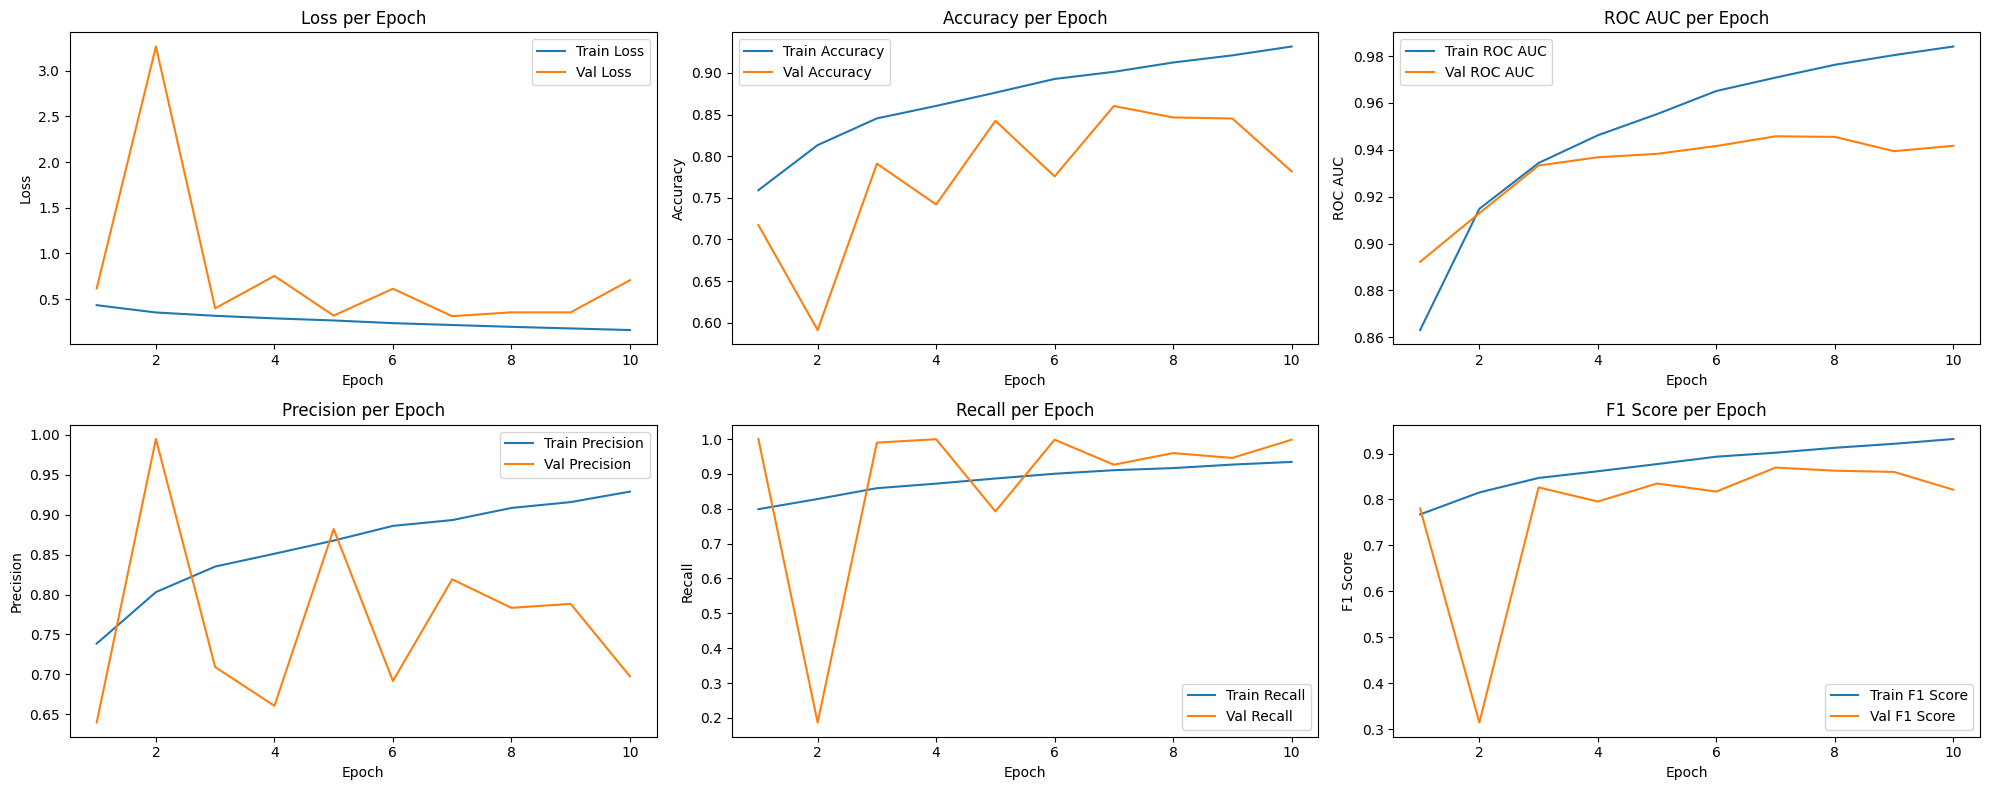

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from huggingface_hub import upload_file
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for x_text, x_num, y in dataloader:
        x_text, x_num, y = x_text.to(device), x_num.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x_text, x_num)

        loss = criterion(outputs, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()  # probabilitas kelas 1
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    acc = accuracy_score(all_labels, pred_labels)
    auc = roc_auc_score(all_labels, all_preds)
    precision = precision_score(all_labels, pred_labels)
    recall = recall_score(all_labels, pred_labels)
    f1 = f1_score(all_labels, pred_labels)

    return avg_loss, acc, auc, precision, recall, f1

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_text, x_num, y in dataloader:
            x_text, x_num, y = x_text.to(device), x_num.to(device), y.to(device)
            outputs = model(x_text, x_num)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            preds = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    acc = accuracy_score(all_labels, pred_labels)
    auc = roc_auc_score(all_labels, all_preds)
    precision = precision_score(all_labels, pred_labels)
    recall = recall_score(all_labels, pred_labels)
    f1 = f1_score(all_labels, pred_labels)

    return avg_loss, acc, auc, precision, recall, f1


# Training loop
num_epochs = 10
best_val_auc = 0.0
best_model_path = "best_gru_bot_model.pth"
repo_id = "yazidsupriadi/gru_bot"

train_losses, train_accs, train_aucs, train_precisions, train_recalls, train_f1s = [], [], [], [], [], []
val_losses, val_accs, val_aucs, val_precisions, val_recalls, val_f1s = [], [], [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc, train_auc, train_precision, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc, val_precision, val_recall, val_f1 = eval_epoch(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"Train - Loss: {train_loss:.4f} Acc: {train_acc:.4f} AUC: {train_auc:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} Acc: {val_acc:.4f} AUC: {val_auc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        print(f"Model terbaik disimpan dengan AUC: {best_val_auc:.4f}")

        # Upload ke HF
        upload_file(
            path_or_fileobj=best_model_path,
            path_in_repo=best_model_path,
            repo_id=repo_id,
            repo_type="model"
        )
        print("Model terbaik berhasil di-upload ke Hugging Face Hub!")

# Plot hasil training termasuk Precision, Recall, F1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_aucs, label="Train ROC AUC")
plt.plot(epochs, val_aucs, label="Val ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("ROC AUC per Epoch")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision per Epoch")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall per Epoch")
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, train_f1s, label="Train F1 Score")
plt.plot(epochs, val_f1s, label="Val F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Final Accuracy : 0.7817
Final Precision: 0.6975
Final Recall   : 0.9980
Final F1-score : 0.8211
Final ROC AUC  : 0.9417

Classification Report:
              precision    recall  f1-score   support

         bot       1.00      0.56      0.72      1992
       human       0.70      1.00      0.82      2008

    accuracy                           0.78      4000
   macro avg       0.85      0.78      0.77      4000
weighted avg       0.85      0.78      0.77      4000



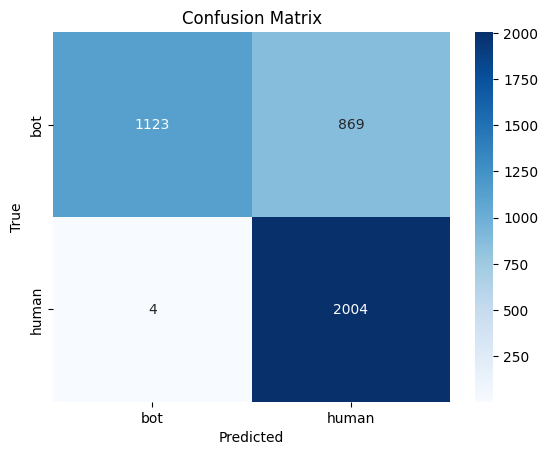

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []
all_probs = []  # untuk menyimpan probabilitas prediksi kelas positif

with torch.no_grad():
    for x_text, x_num, y in test_loader:
        x_text, x_num = x_text.to(device), x_num.to(device)
        outputs = model(x_text, x_num)

        probs = torch.softmax(outputs, dim=1)  # Ambil probabilitas jika multiclass
        preds = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

        all_probs.extend(probs[:, 1].cpu().numpy())  # Ambil probabilitas kelas positif

# Hitung metrik
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
auc = roc_auc_score(all_labels, all_probs)  # Gunakan probabilitas, bukan prediksi argmax

# Cetak hasil
print(f"Final Accuracy : {acc:.4f}")
print(f"Final Precision: {prec:.4f}")
print(f"Final Recall   : {rec:.4f}")
print(f"Final F1-score : {f1:.4f}")
print(f"Final ROC AUC  : {auc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
